# Correlations 7S
fistly define the UUID of the experiment to use

In [4]:
experimentId="09aa67d8-c865-4a95-a7c5-de7b6adadbce"

-------------------------------------------------------

In [5]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.stats as sst
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load cognition

In [6]:
samplerate=200  #Should rethink this

In [7]:
annotations, signalsMetadata = loadCOGNITIONSpindles(cognipath)

In [8]:
annotations.head()

,subjectId,channel,startTime,stopTime,duration,phase,labelerId,type,samplerate,startInd,stopInd
0,0001,C3,1938.132297,1939.202326,1.070029,2,0001,spindle,200,387626,387840
1,0001,C3,2047.217898,2048.112834,0.894936,2,0001,spindle,200,409444,409623
2,0001,C3,2170.856032,2171.634237,0.778205,3,0001,spindle,200,434171,434327
3,0001,C3,2219.766538,2220.894943,1.128405,3,0001,spindle,200,443953,444179
4,0001,C3,2263.482492,2264.357974,0.875482,3,0001,spindle,200,452696,452872


In [9]:
signalsMetadata.head()

,filename,channel,subjectId,duration,samplerate,isOriginalSamplerate,database
0,COG001_canal_C3.txt,C3-M2,0001,39600,200,False,COGNITION
1,COG002_canal_C3.txt,C3-M2,0002,39600,200,False,COGNITION
2,COG003_canal_C3.txt,C3-M2,0003,39600,200,False,COGNITION
3,COG004_canal_C3.txt,C3-M2,0004,39600,200,False,COGNITION
4,COG005_canal_C3.txt,C3-M2,0005,39600,200,False,COGNITION


## Load experiment results

In [10]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [11]:
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0004, 0005, 0006, 0007]","[0003, 0008]",0002,9e8c92c9-d012-4e46-a60f-74540df5103d,0.008075
1,0001,E1,[0001],"[0002, 0005, 0006, 0008]","[0007, 0004]",0003,16258fa7-20b7-495e-a32f-75aec610ef66,0.005000
2,0001,E1,[0001],"[0002, 0003, 0005, 0007]","[0006, 0008]",0004,3654a0cd-77b5-4bcf-8238-54296d7c1a27,0.012035
3,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0006, 0004]",0005,8cec6075-9679-4f7b-b5c7-d6ff36147e79,0.010340
4,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0004, 0005]",0006,5401bdbe-22c1-42a0-9740-d2921a271387,0.010340
5,0001,E1,[0001],"[0002, 0004, 0005, 0008]","[0003, 0006]",0007,2d237bf5-9265-439a-827b-f1411cb4fc3a,0.006673
6,0001,E1,[0001],"[0002, 0005, 0006, 0007]","[0003, 0004]",0008,8bf430c8-bbc9-4ee2-927e-75f7a5e76570,0.006822


In [12]:
#we show the difference in class inbalance for the annotation criteria considered
experimentModels[['criteriumName','spindleTimeRate']].groupby('criteriumName').describe()

spindleTimeRate                                                 \
                        count      mean       std    min       25%       50%   
criteriumName                                                                  
E1                        7.0  0.008469  0.002511  0.005  0.006748  0.008075   

                                  
                   75%       max  
criteriumName                     
E1             0.01034  0.012035

In [13]:
featureSelection

,window,characteristic,bandName,score
0,2,hjortActivity,beta2,69.0
1,1,hjortActivity,sigma,63.0
2,2,hjortActivity,beta1,42.0
3,2,hjortActivity,delta2,41.0
4,1.5,sigmaIndex,broadband,39.0
5,2,sigmaIndex,broadband,39.0
6,2,hjortActivity,theta,38.0
7,2,hjortMobility,beta1,37.0
8,2,hjortActivity,alpha,35.0
9,1,sigmaIndex,broadband,34.0


## Hyperparameter definition
this should come from a previous evaluation notebook

In [14]:
hyperClose=0.1
hyperDuration=0.3
hyperThres=0.4
hyperDepth=10

## Testing with E1 criterium
we test the optimal points for the prediction threshold and number of boost iterations in the different validation groups

In [15]:
experimentModels=experimentModels[experimentModels.criteriumName=='E1'].reset_index(drop=True)
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0004, 0005, 0006, 0007]","[0003, 0008]",0002,9e8c92c9-d012-4e46-a60f-74540df5103d,0.008075
1,0001,E1,[0001],"[0002, 0005, 0006, 0008]","[0007, 0004]",0003,16258fa7-20b7-495e-a32f-75aec610ef66,0.005000
2,0001,E1,[0001],"[0002, 0003, 0005, 0007]","[0006, 0008]",0004,3654a0cd-77b5-4bcf-8238-54296d7c1a27,0.012035
3,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0006, 0004]",0005,8cec6075-9679-4f7b-b5c7-d6ff36147e79,0.010340
4,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0004, 0005]",0006,5401bdbe-22c1-42a0-9740-d2921a271387,0.010340
5,0001,E1,[0001],"[0002, 0004, 0005, 0008]","[0003, 0006]",0007,2d237bf5-9265-439a-827b-f1411cb4fc3a,0.006673
6,0001,E1,[0001],"[0002, 0005, 0006, 0007]","[0003, 0004]",0008,8bf430c8-bbc9-4ee2-927e-75f7a5e76570,0.006822


In [16]:
allTablesOut=pd.DataFrame({})
allDetections=[]
allAnnotations=[]

for ind,row in experimentModels.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModels)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.test
    #Define annotations criterium
    usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres
    
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)
    
    #By-event tables
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    processedAnnotations=processedAnnotations[processedAnnotations.duration<5].reset_index(drop=True)
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    tableOut,tableGT=getMetricTables(gtAnnotations,processedAnnotations)
    
    #Process tables
    gtAnnotations['durationGT']=gtAnnotations['duration']
    tableOut=pd.merge(tableOut,gtAnnotations["durationGT"],"left",left_on="indexGT",right_index=True)
    processedAnnotations['durationOut']=processedAnnotations['duration']
    tableOut=pd.merge(tableOut,processedAnnotations["durationOut"],"left",left_on="indexOut",right_index=True)

    tableOut['subjectId']=row.test

    allTablesOut=pd.concat((allTablesOut,tableOut))
    allDetections.append(processedAnnotations)
    allAnnotations.append(gtAnnotations)


*************************
1 of 7
*************************
2 of 7
*************************
3 of 7
*************************
4 of 7
*************************
5 of 7
*************************
6 of 7
*************************
7 of 7


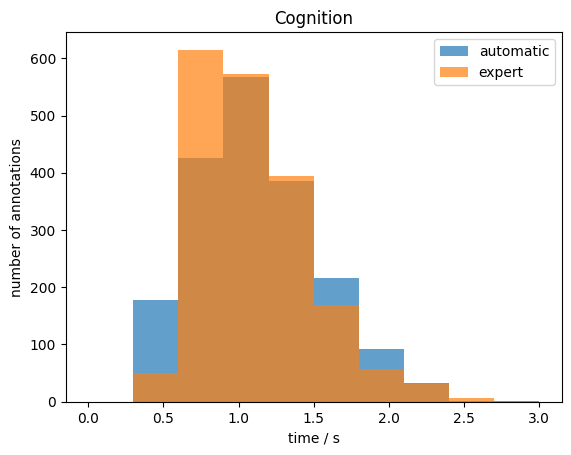

In [17]:
plt.hist(allTablesOut[allTablesOut.tp].durationOut,range=[0,3],alpha=0.7,label='automatic')
plt.hist(allTablesOut[allTablesOut.tp].durationGT,range=[0,3],alpha=0.7,label='expert')
plt.legend()
plt.xlabel("time / s")
plt.ylabel("number of annotations")
plt.title("Cognition")
plt.show()


In [18]:
px.scatter(allTablesOut[allTablesOut.tp],x="durationGT",y="durationOut",trendline="lowess")

In [19]:
result=sst.linregress(allTablesOut[allTablesOut.tp].durationGT,allTablesOut[allTablesOut.tp].durationOut)

In [20]:
result

LinregressResult(slope=0.6913653220238674, intercept=0.35679795484156007, rvalue=0.6228191886215201, pvalue=2.3623287256908156e-204, stderr=0.019945103924005027, intercept_stderr=0.02319449307350586)

In [21]:
result.pvalue

2.3623287256908156e-204

In [22]:
result.rvalue**2

0.3879037417151686

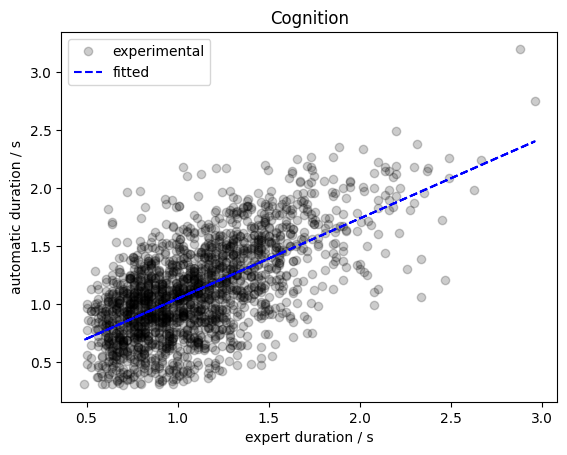

In [23]:
plt.plot(allTablesOut[allTablesOut.tp].durationGT,allTablesOut[allTablesOut.tp].durationOut,linestyle='',marker='o',color='black',alpha=0.2,label='experimental')
plt.plot(allTablesOut[allTablesOut.tp].durationGT, result.intercept + result.slope*np.array(allTablesOut[allTablesOut.tp].durationGT), 'b', label='fitted',linestyle='--')
plt.legend()
plt.xlabel("expert duration / s")
plt.ylabel("automatic duration / s")
plt.title("Cognition")
plt.show()

### Correlation of number of detections

In [24]:
detectionNumber=list(map(lambda x: len(x),allDetections))
annotationNumber=list(map(lambda x: len(x),allAnnotations))

In [25]:
res=sst.linregress(annotationNumber,detectionNumber)
res

LinregressResult(slope=1.016662294161791, intercept=34.26582795921962, rvalue=0.8724173508146302, pvalue=0.010413223589565541, stderr=0.2547208859798501, intercept_stderr=107.44473425478417)

In [26]:
res.pvalue

0.010413223589565541

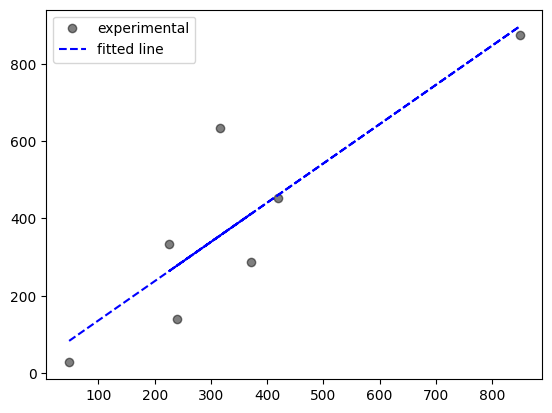

In [27]:
plt.plot(annotationNumber,detectionNumber,linestyle='',marker='o',color='black',alpha=0.5,label='experimental')
plt.plot(annotationNumber, res.intercept + res.slope*np.array(annotationNumber), 'b', linestyle='--', label='fitted line')
plt.legend()
plt.show()


### Correlations of density of spindles

In [28]:
signalsMetadata.head()

,filename,channel,subjectId,duration,samplerate,isOriginalSamplerate,database
0,COG001_canal_C3.txt,C3-M2,0001,39600,200,False,COGNITION
1,COG002_canal_C3.txt,C3-M2,0002,39600,200,False,COGNITION
2,COG003_canal_C3.txt,C3-M2,0003,39600,200,False,COGNITION
3,COG004_canal_C3.txt,C3-M2,0004,39600,200,False,COGNITION
4,COG005_canal_C3.txt,C3-M2,0005,39600,200,False,COGNITION


In [29]:
durations=signalsMetadata.duration

In [30]:
detectionDensity=list(map(lambda x: len(x[0])/(x[1]/3600),zip(allDetections,durations)))
annotationDensity=list(map(lambda x: len(x[0])/(x[1]/3600),zip(allAnnotations,durations)))

In [31]:
res=sst.linregress(annotationDensity,detectionDensity)
print(res)

LinregressResult(slope=1.0166622941617909, intercept=3.1150752690199823, rvalue=0.8724173508146302, pvalue=0.010413223589565541, stderr=0.25472088597985004, intercept_stderr=9.767703114071283)


In [32]:
res.rvalue**2

0.7611120340024176

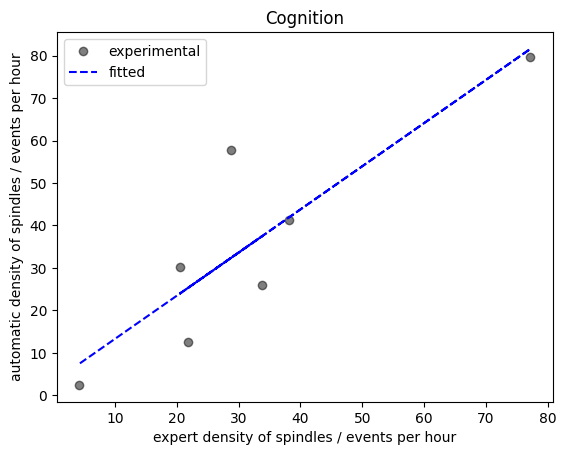

In [33]:
plt.plot(annotationDensity,detectionDensity,linestyle='',marker='o',color='black',alpha=0.5,label='experimental')
plt.plot(annotationDensity, res.intercept + res.slope*np.array(annotationDensity), 'b', linestyle='--', label='fitted')
plt.legend()
plt.xlabel("expert density of spindles / events per hour")
plt.ylabel("automatic density of spindles / events per hour")
plt.title("Cognition")
plt.show()

## Can we visualise the results?

In [34]:
row

criteriumId                                        0001
criteriumName                                        E1
labelerIdList                                    [0001]
train                          [0002, 0005, 0006, 0007]
val                                        [0003, 0004]
test                                               0008
modelId            8bf430c8-bbc9-4ee2-927e-75f7a5e76570
spindleTimeRate                                0.006822
Name: 6, dtype: object

In [35]:
testSubjectId

'0008'

In [36]:
signals, _, _ = loadCOGNITIONSpindles(cognipath,returnSignals=True)

In [37]:
signal=signals[testSubjectId]

In [60]:
i=4

In [61]:
minutes=120
roi=np.array([i*(minutes*60*200),(i+1)*(minutes*60*200)])
timepoints=np.arange(roi[0],roi[1])/(200*60)

In [ ]:
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=timepoints,y=signal[roi[0]:roi[1]],name='signal'), secondary_y=True)
fig.add_trace(go.Scatter(x=timepoints,y=testLabels[roi[0]:roi[1]], fill='tozeroy',mode='none',name='manual'))
fig.add_trace(go.Scatter(x=timepoints,y=processedLabels[roi[0]:roi[1]]*1, fill='tozeroy',mode='none',name='automatic'))
fig.show()

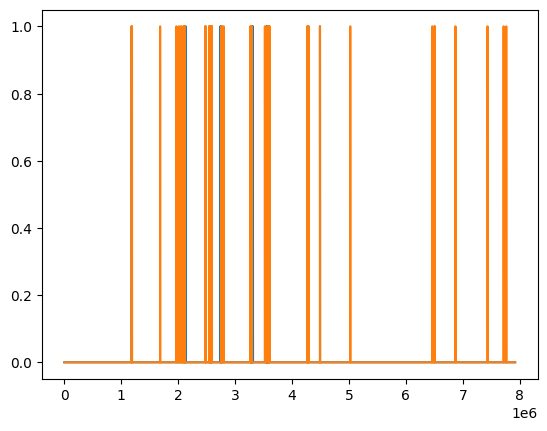

In [41]:
plt.plot(processedLabels)
plt.plot(testLabels)

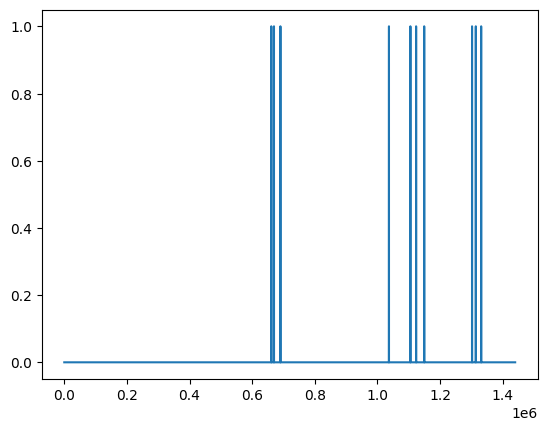

In [42]:
plt.plot(processedLabels[roi[0]:roi[1]])